# Common
## Imports

In [11]:
from platform import python_version

print(python_version())

3.11.1


In [12]:
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

# Helper Functions

In [13]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 25
    cols = 25
    
    # reshape policy array to be 2-D - assumes 500 states...
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(25):
        for j in range(25):
            y = 25 - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')
    
    plt.axis('off')
    # plt.savefig('./forest/' + title + '.png', dpi=400)
    
    
#plot_forest(bestPolicy)

# Setup Problem

In [14]:
T,R = hiive.mdptoolbox.example.forest(S=625)

# Value Iteration
## Function

In [15]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            testNum = testNum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # See differences in policy
    policies = data['policy']
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [16]:
gammas   = [0.1, 0.3, 0.6, 0.9, 0.99]
epsilons = [1e-2, 1e-5, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	2,	4.360000
0.10,	1E-05,	0.01,	5,	4.396585
0.10,	1E-08,	0.01,	8,	4.396613
0.10,	1E-12,	0.01,	12,	4.396613
0.30,	1E-02,	0.00,	4,	5.460862
0.30,	1E-05,	0.00,	10,	5.491919
0.30,	1E-08,	0.01,	15,	5.491933
0.30,	1E-12,	0.01,	22,	5.491933
0.60,	1E-02,	0.00,	11,	8.797055
0.60,	1E-05,	0.01,	22,	8.809969
0.60,	1E-08,	0.01,	33,	8.809994
0.60,	1E-12,	0.01,	48,	8.809994
0.90,	1E-02,	0.01,	39,	23.089675
0.90,	1E-05,	0.03,	72,	23.170025
0.90,	1E-08,	0.03,	105,	23.172360
0.90,	1E-12,	0.05,	149,	23.172433
0.99,	1E-02,	0.03,	92,	60.701641
0.99,	1E-05,	0.05,	152,	69.211354
0.99,	1E-08,	0.07,	212,	73.867071
0.99,	1E-12,	0.09,	292,	76.974951
Time taken: 0.58


In [17]:
policies = vi_data['policy']

## Results

Best Result:
	Reward = 76.97
	Gamma = 0.9900000
	Epsilon= 1E-12


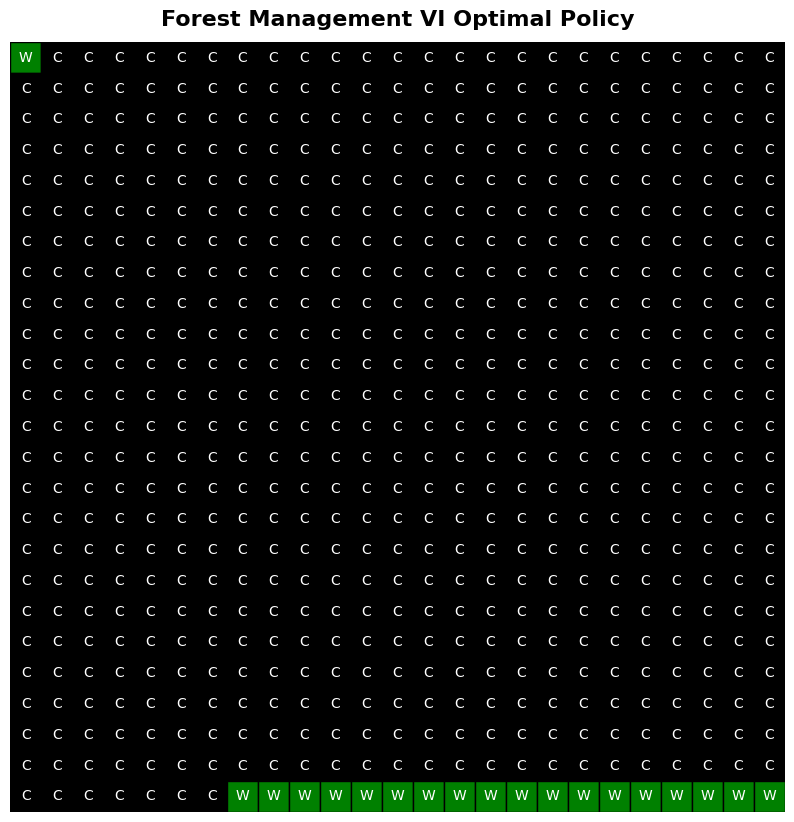

In [18]:
# find the highest score
bestRun = vi_data['reward'].argmax()
bestPolicy = vi_data['policy'][bestRun]

title='Forest Management VI Optimal Policy'
plot_forest(bestPolicy, title)

# Save off data to a csv file
# vi_data.to_csv('forest/VI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\tEpsilon= %.E' % (vi_data['reward'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))


# Policy Iteration
## Function

In [19]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            plot_forest(policy, title)
            pass
        
        testnum = testnum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [20]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
pi_data  = policyIteration(T, R, gammas, showResults=False)

#pi_data.head()

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.31,	1,	4.396613
0.20,	0.12,	1,	4.882699
0.30,	0.15,	2,	5.491933
0.40,	0.06,	2,	6.277574
0.50,	0.13,	3,	7.329154
0.60,	0.14,	3,	8.809994
0.70,	0.21,	5,	11.054551
0.80,	0.38,	6,	14.883721
0.90,	0.48,	10,	23.172434
0.99,	0.79,	18,	79.492429
Time taken: 2.81


## Results

Best Result:
	Reward = 79.49
	Gamma = 0.990


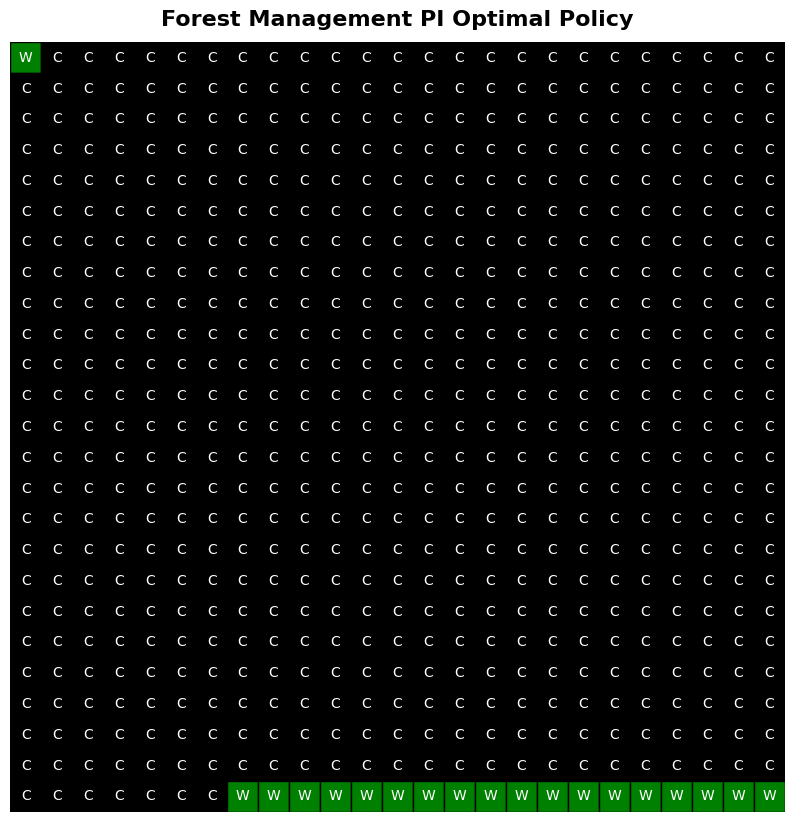

In [22]:
# find the highest score
bestRun = pi_data['reward'].argmax()
bestPolicy = pi_data['policy'][bestRun]

title='Forest Management PI Optimal Policy'
plot_forest(bestPolicy, title)

# Save off data to a csv file
# pi_data.to_csv('forest/PI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.3f' % (pi_data['reward'].max(), pi_data['gamma'][bestRun]))


# Q-Learning
## Function

In [23]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        #policy = np.array(test.policy)
                        #policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            pass
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    '''
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
    '''
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [ ]:
gammas         = [0.8, 0.9, 0.99]
alphas         = [0.01, 0.1, 0.2]
alpha_decays   = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations     = [1e5, 1e6, 1e7]

# PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)

# write all results to csv file
csvFile = 'forest/QL_results.csv'
ql_data.to_csv(csvFile)

ql_data.head()

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	5.03,	100000,	2.668032
Test Num 2/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	46.56,	1000000,	2.678451
Test Num 3/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.80,	0.01,	451.28,	10000000,	4.722792
Test Num 4/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	5.02,	100000,	2.674275
Test Num 5/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.01,	46.52,	1000000,	2.676825
Test Num 6/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000000
0.80,	0.01,	450.90,	10000000,	3.532889
Test Num 7/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsi

0.90,	0.10,	46.81,	1000000,	5.024306
Test Num 60/108
Gamma: 0.90,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000000
0.90,	0.10,	460.40,	10000000,	5.026743
Test Num 61/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.90,	0.20,	5.02,	100000,	4.985333
Test Num 62/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.90,	0.20,	46.94,	1000000,	5.025373
Test Num 63/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.90,	0.20,	465.29,	10000000,	7.726936
Test Num 64/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.90,	0.20,	5.01,	100000,	4.970744
Test Num 65/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.90,	0.20,	48.22,	1000000,	5.030004
Test Num 66/108
Gamma: 0.90,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000000
0.90,	0.20,	481.34,	10000000,	7.7

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.9,0.900,100000.0,5.031898,2.668032,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,...","{(1.6e-05, 1.6e-05, 1.6e-05, 1.6e-05, 1.6e-05,...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.38..."
1,0.8,0.01,0.9,0.900,1000000.0,46.560156,2.678451,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,...","{(8.236472286496183e-05, 0.0001382634139595224...","{(0.033134426034374304, 0.04753641996650868, 0...","{(0.0, 0.0, 0.0, 0.0, 0.0, 9.361986065990639e-..."
2,0.8,0.01,0.9,0.900,10000000.0,451.275376,4.722792,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,...","{(0.000584208440679025, 0.0011847944937786723,...","{(0.26625076453995544, 0.5170525734711292, 0.7...","{(0.0010189230081535546, 0.0, 0.0, 0.0, 2.5474..."
3,0.8,0.01,0.9,0.999,100000.0,5.017631,2.674275,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,...","{(3.619341006490812e-05, 4.442842816290353e-05...","{(0.01, 0.010435820534575587, 0.01340168829287...","{(1.6471290567571935e-05, 7.878167217468897e-0..."
4,0.8,0.01,0.9,0.999,1000000.0,46.515526,2.676825,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,...","{(6.303303328198855e-05, 0.0001079622392218077...","{(0.0148288765186204, 0.030479044905281055, 0....","{(0.0, 0.001000546223763191, 0.001001068084960..."


In [ ]:
# Read in Q-Learning data
ql_data = pd.read_csv('forest/QL_results.csv')
ql_data.head()

,Unnamed: 0,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0,0.8,0.01,0.9,0.900,100000.0,5.031898,2.668032,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,...","{(1.6e-05, 1.6e-05, 1.6e-05, 1.6e-05, 1.6e-05,...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.38..."
1,1,0.8,0.01,0.9,0.900,1000000.0,46.560156,2.678451,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,...","{(8.236472286496183e-05, 0.0001382634139595224...","{(0.033134426034374304, 0.04753641996650868, 0...","{(0.0, 0.0, 0.0, 0.0, 0.0, 9.361986065990639e-..."
2,2,0.8,0.01,0.9,0.900,10000000.0,451.275376,4.722792,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,...","{(0.000584208440679025, 0.0011847944937786723,...","{(0.26625076453995544, 0.5170525734711292, 0.7...","{(0.0010189230081535546, 0.0, 0.0, 0.0, 2.5474..."
3,3,0.8,0.01,0.9,0.999,100000.0,5.017631,2.674275,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,...","{(3.619341006490812e-05, 4.442842816290353e-05...","{(0.01, 0.010435820534575587, 0.01340168829287...","{(1.6471290567571935e-05, 7.878167217468897e-0..."
4,4,0.8,0.01,0.9,0.999,1000000.0,46.515526,2.676825,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,...","{(6.303303328198855e-05, 0.0001079622392218077...","{(0.0148288765186204, 0.030479044905281055, 0....","{(0.0, 0.001000546223763191, 0.001001068084960..."


In [ ]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

## Results

Best Result:
	Reward = 47.68
	Gamma = 0.99,
	Alpha = 0.01,
	Alpha Decay: 0.900,
	Epsilon Decay: 0.999,
	Iterations: 1.0E+07


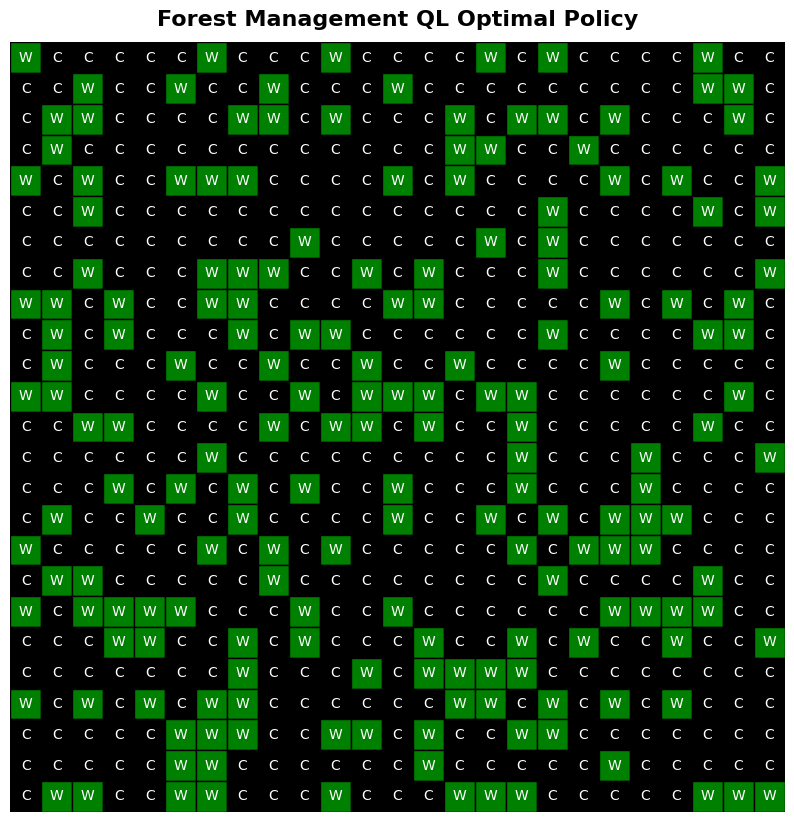

In [ ]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = ql_data['reward'].argmax()

best_policy = ql_data['policy'][bestRun]

# reshape the policy since we pulled from a csv file
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(25, 25)

# plot the policy
title='Forest Management QL Optimal Policy'
plot_forest(best_policy, title)

print('Best Result:\n\tReward = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' 
      % (ql_data['reward'].max(), ql_data['gamma'][bestRun], ql_data['alpha'][bestRun], ql_data['alpha_decay'][bestRun], ql_data['epsilon_decay'][bestRun], ql_data['iterations'][bestRun]))